In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

In [17]:
# Load the datasets
daily_activity = pd.read_csv('dailyActivity_merged.csv')
sleep_data = pd.read_csv('sleepDay_merged.csv')
hourly_calories = pd.read_csv('hourlyCalories_merged.csv')
hourly_intensities = pd.read_csv('hourlyIntensities_merged.csv')
hourly_steps = pd.read_csv('hourlySteps_merged.csv')
minute_sleep = pd.read_csv('minuteSleep_merged.csv')
minute_METs = pd.read_csv('minuteMETsNarrow_merged.csv')
heartrate_seconds = pd.read_csv('heartrate_seconds_merged.csv')
weight_log = pd.read_csv('weightLogInfo_merged.csv')

In [18]:
# Find out the unique Ids in each csv files
print(daily_activity['Id'].nunique())
print(sleep_data['Id'].nunique())
print(hourly_calories['Id'].nunique())
print(hourly_intensities['Id'].nunique())
print(hourly_steps['Id'].nunique())
print(minute_sleep['Id'].nunique())
print(minute_METs['Id'].nunique())
print(heartrate_seconds['Id'].nunique())
print(weight_log['Id'].nunique())

33
24
33
33
33
24
33
14
8


In [19]:
# Load the csv files into dataframes
dataframes = {
    "Daily Activity": daily_activity,
    "Heart Rate (Seconds)": heartrate_seconds,
    "Hourly Calories": hourly_calories,
    "Hourly Intensities": hourly_intensities,
    "Hourly Steps": hourly_steps,
    "Minute Sleep": minute_sleep,
    "Sleep Day": sleep_data,
    "Weight Log Info": weight_log,
    "Minute METs Narrow": minute_METs
}

In [20]:
# Sum the total minutes for each intensity level
intensity_totals = {
    'Very Active': daily_activity['VeryActiveMinutes'].sum(),
    'Fairly Active': daily_activity['FairlyActiveMinutes'].sum(),
    'Lightly Active': daily_activity['LightlyActiveMinutes'].sum(),
    'Sedentary': daily_activity['SedentaryMinutes'].sum()
}

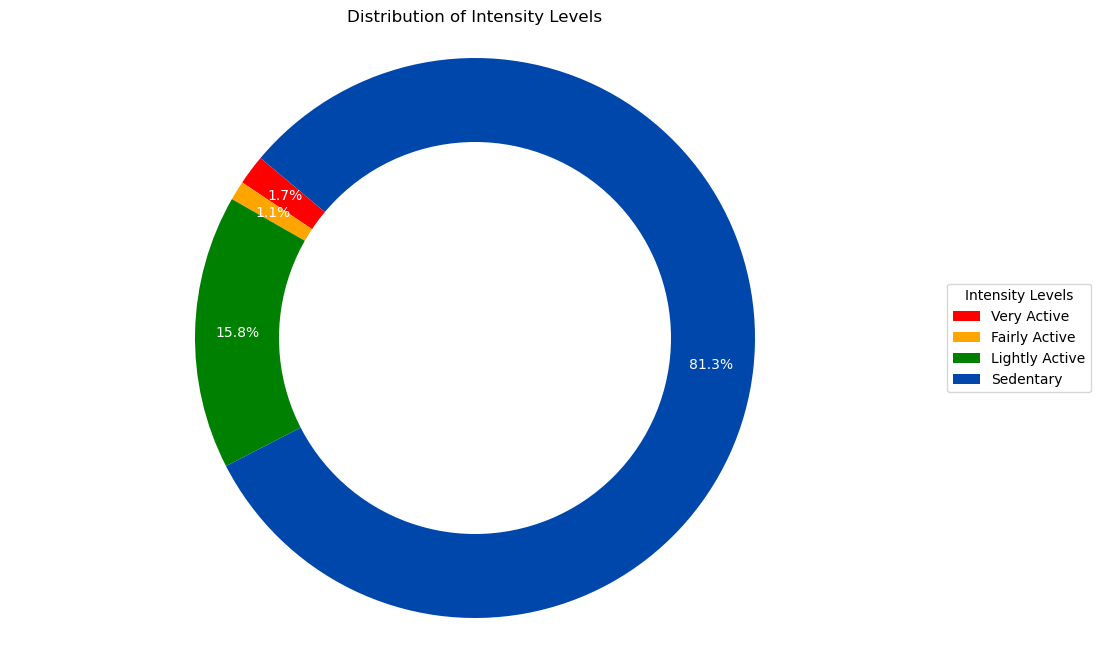

In [21]:
# Prepare data for pie chart
labels = list(intensity_totals.keys())
sizes = list(intensity_totals.values())
colors = ['red', 'orange', 'green', '#0047ab']

# Plot the pie chart
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
                                   startangle=140, pctdistance=0.85, textprops=dict(color="w"))

# Draw a circle at the center to make it look like a donut chart
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a legend outside the pie chart
plt.legend(wedges, labels, title="Intensity Levels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

plt.title('Distribution of Intensity Levels')
plt.show()

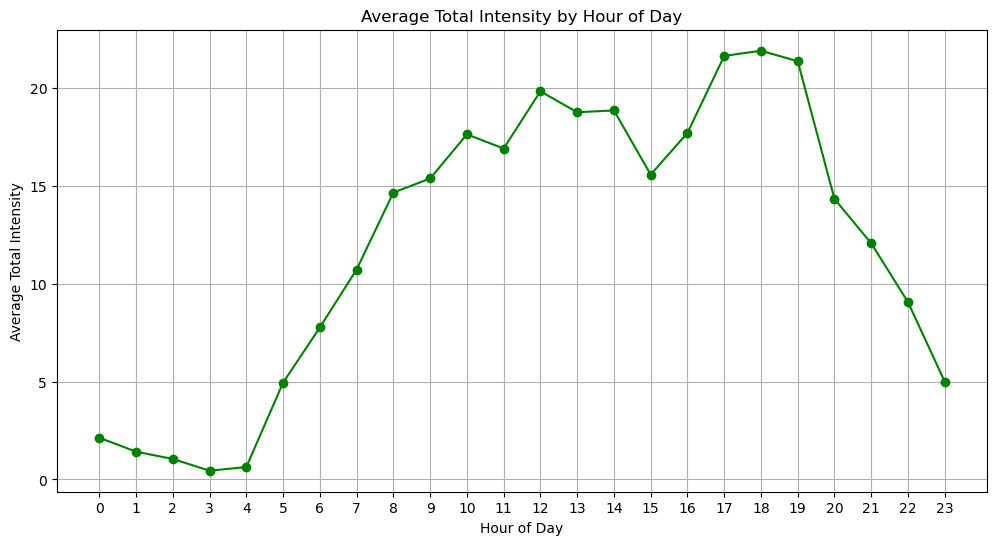

In [23]:
# Convert the ActivityHour column to datetime
hourly_intensities['ActivityHour'] = pd.to_datetime(hourly_intensities['ActivityHour'])

# Extract the hour from the ActivityHour column
hourly_intensities['Hour'] = hourly_intensities['ActivityHour'].dt.hour

# Calculate the average intensity for each hour of the day
average_intensity_by_hour = hourly_intensities.groupby('Hour')['TotalIntensity'].mean().reset_index()

# Plot the average intensity by hour of day
plt.figure(figsize=(12, 6))
plt.plot(average_intensity_by_hour['Hour'], average_intensity_by_hour['TotalIntensity'], marker='o', linestyle='-', color='green')
plt.xlabel('Hour of Day')
plt.ylabel('Average Total Intensity')
plt.title('Average Total Intensity by Hour of Day')
plt.xticks(range(24))
plt.grid(True)
plt.show()

In [25]:
# Convert the SleepDay column to datetime format
sleep_data['SleepDay'] = pd.to_datetime(sleep_data['SleepDay']).dt.date

# Create the "Time to Fall Asleep" column by subtracting TotalMinutesAsleep from TotalTimeInBed
sleep_data['TimeToFallAsleep'] = sleep_data['TotalTimeInBed'] - sleep_data['TotalMinutesAsleep']

# Display the first few rows to check the new column
sleep_data.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TimeToFallAsleep
0,1503960366,2016-04-12,1,327,346,19
1,1503960366,2016-04-13,2,384,407,23
2,1503960366,2016-04-15,1,412,442,30
3,1503960366,2016-04-16,2,340,367,27
4,1503960366,2016-04-17,1,700,712,12


In [27]:
# Convert the ActivityHour column to datetime format
hourly_calories['ActivityHour'] = pd.to_datetime(hourly_calories['ActivityHour'])

# Display the first few rows to understand the structure
hourly_calories.head()

,Id,ActivityHour,Calories
0,1503960366,2016-04-12 00:00:00,81
1,1503960366,2016-04-12 01:00:00,61
2,1503960366,2016-04-12 02:00:00,59
3,1503960366,2016-04-12 03:00:00,47
4,1503960366,2016-04-12 04:00:00,48


In [29]:
# Aggregate the hourly calories data to daily level
hourly_calories['Date'] = hourly_calories['ActivityHour'].dt.date
daily_calories = hourly_calories.groupby(['Id', 'Date']).agg({'Calories': 'sum'}).reset_index()

# Merge the daily calories data with the sleep data on Id and Date
merged_df = pd.merge(sleep_data, daily_calories, left_on=['Id', 'SleepDay'], right_on=['Id', 'Date'], how='inner')

# Drop the redundant Date column
merged_df.drop(columns=['Date'], inplace=True)

# Display the first few rows of the merged dataframe
merged_df.head()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TimeToFallAsleep,Calories
0,1503960366,2016-04-12,1,327,346,19,1988
1,1503960366,2016-04-13,2,384,407,23,1798
2,1503960366,2016-04-15,1,412,442,30,1745
3,1503960366,2016-04-16,2,340,367,27,1866
4,1503960366,2016-04-17,1,700,712,12,1730


In [30]:
# Calculate the correlation between TimeToFallAsleep and Calories burned
correlation = merged_df[['TimeToFallAsleep', 'Calories']].corr()
print(correlation)

                  TimeToFallAsleep  Calories
TimeToFallAsleep          1.000000 -0.292149
Calories                 -0.292149  1.000000


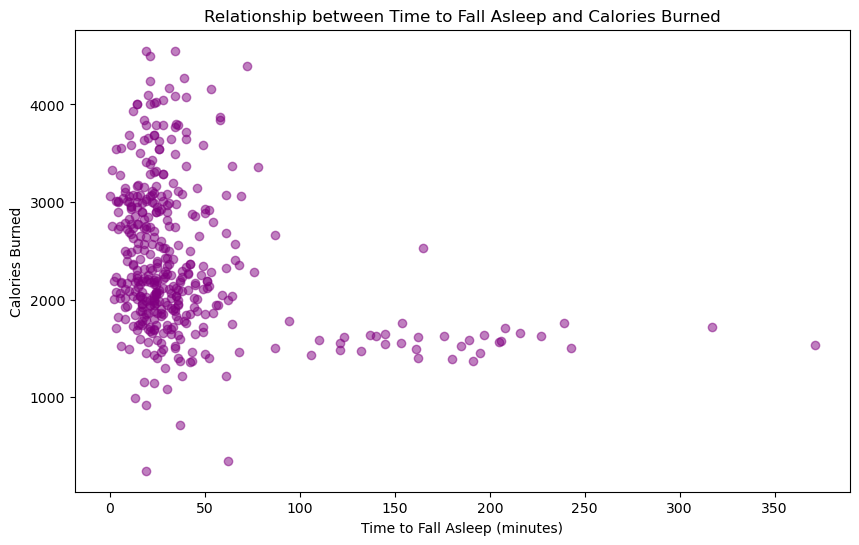

In [31]:
# Scatter plot for TimeToFallAsleep vs Calories burned
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['TimeToFallAsleep'], merged_df['Calories'], alpha=0.5, color='purple')
plt.xlabel('Time to Fall Asleep (minutes)')
plt.ylabel('Calories Burned')
plt.title('Relationship between Time to Fall Asleep and Calories Burned')
plt.show()

In [ ]:
# The scatter plot shows a weak to moderate inverse relationship between the time to fall asleep and calories burned. As the calories burned increase, the time to fall asleep generally decreases.
# Most data points are concentrated in the lower range of time to fall asleep (0-50 minutes) and a relatively higher range of calories burned (1500-3000 calories). This suggests that individuals who burn a higher calories tend to fall asleep more quickly. These outliers indicate that some individuals may have sleep issues unrelated to calorie expenditure.
# The outliers indicate that some individuals may have sleep issues unrelated to calorie burned.
# Factors like stress, sleep environment, and overall health could also be playing a role.
